In [1]:
import nengo
import nengo.spa as spa
import numpy as np
from nengo.spa import Vocabulary
import matplotlib.pyplot as plt

In [2]:
dim = 32
rng = np.random.RandomState(4)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)

In [3]:
CIRCLE = vocab.parse("CIRCLE")
BLUE = vocab.parse("BLUE")
RED = vocab.parse("RED")
SQUARE = vocab.parse("SQUARE")
ZERO = vocab.add("ZERO", [0] * dim)

In [6]:
model = spa.SPA(label="Question Answering with Memory", vocabs=[vocab])
with model:
    model.Shape = spa.State(dim)
    model.Color = spa.State(dim)
    model.Cue = spa.State(dim)
    model.Object = spa.State(dim)
    model.Answer = spa.State(dim)
    model.memory = spa.State(dim, feedback=1)

    actions = spa.Actions("Object = Shape * Color", "memory = Object", "Answer = memory * ~Cue")

    model.cortical = spa.Cortical(actions)

    # Function for providing color input
    def color_input(t):
        if t < 0.25:
            return "RED"
        elif t < 0.5:
            return "BLUE"
        return "ZERO"

    # Function for providing shape input
    def shape_input(t):
        if t < 0.25:
            return "CIRCLE"
        elif t < 0.5:
            return "SQUARE"
        return "ZERO"

    # Function for providing the cue
    def cue_input(t):
        if t < 0.5:
            return "ZERO"
        sequence = ["ZERO", "CIRCLE", "RED", "ZERO", "SQUARE", "BLUE"]
        idx = int(((t - 0.5) // (1.0 / len(sequence))) % len(sequence))
        return sequence[idx]

    # Inputs
    model.input = spa.Input(Shape=shape_input, Color=color_input, Cue=cue_input)

    shape_probe = nengo.Probe(model.Shape.output, synapse=0.01)
    color_probe = nengo.Probe(model.Color.output, synapse=0.01)
    cue_probe = nengo.Probe(model.Cue.output, synapse=0.01)
    answer_probe = nengo.Probe(model.Answer.output, synapse=0.01)

In [7]:
sim = nengo.Simulator(model)
with sim:
    sim.run(3.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [8]:
cue = {k : np.dot(sim.data[cue_probe], v) for k, v in zip(vocab.keys, vocab.vectors)}
answer = {k : np.dot(sim.data[answer_probe], v) for k, v in zip(vocab.keys, vocab.vectors)}
shape = {k : np.dot(sim.data[shape_probe], v) for k, v in zip(vocab.keys, vocab.vectors)}
color = {k : np.dot(sim.data[color_probe], v) for k, v in zip(vocab.keys, vocab.vectors)}

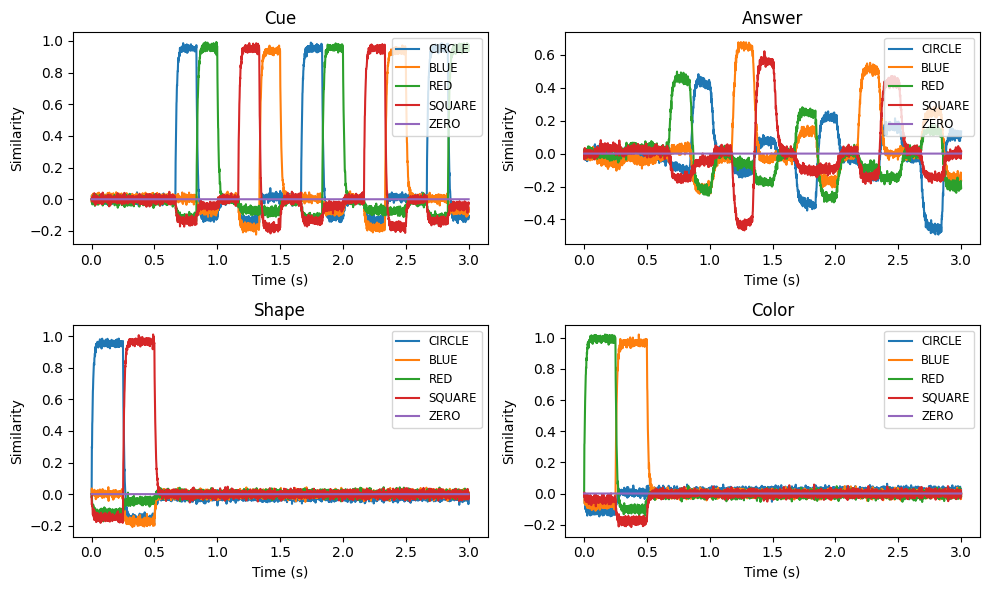

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

data = {"Cue": cue, "Answer": answer, "Shape": shape, "Color": color}

for ax, (title, d) in zip(axs.flatten(), data.items()):
    for k, v in d.items():
        ax.plot(sim.trange(), v, label=k)
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize="small")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Similarity")

plt.tight_layout()
plt.show()